Start By downloading the data as provided in the example colab

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd

from gensim.models import Word2Vec

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Seperate out the testing and training data
imdb, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
train_df = tfds.as_dataframe(imdb['train'], info)

Look at the training data

In [ ]:
train_df.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


Convert the text into useful tokens, we do this by getting rid of useless words standaradizing the words into lowercase and getting rid of punctuation

In [ ]:
#Create the vectors
import string
vector_column = []
#go through every reveiw
for review in train_df.text:
  #convert it to a string
  review = str(review)
  #use the library to convert them into tokens which splits on spaces
  tokens = word_tokenize(review)
  #lowercase all the words
  tokens = [w.lower() for w in tokens]
  #get rid of punctuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  #get rid of meaningless stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  #add all the words together
  vector_column.append(words)

In [ ]:
train_df['tokens'] = vector_column
train_df.head()

,label,text,tokens
0,0,"b""This was an absolutely terrible movie. Don't...","[b, , absolutely, terrible, movie, , nt, lured..."
1,0,b'I have been known to fall asleep during film...,"[b, , known, fall, asleep, films, , usually, d..."
2,0,b'Mann photographs the Alberta Rocky Mountains...,"[bmann, photographs, alberta, rocky, mountains..."
3,1,b'This is the kind of film for a snowy Sunday ...,"[bthis, kind, film, snowy, sunday, afternoon, ..."
4,1,"b'As others have mentioned, all the women that...","[bas, others, mentioned, , women, go, nude, fi..."


In [ ]:
#create a word to vec model which can convert the words we need to a vec
encoding_column = []
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


#Create a model using genism Word2Vec with the sentences that we just got from our dataset and for each word make a vector of size 100
model = Word2Vec(sentences=train_df.tokens, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")


In [ ]:
encoding_column = []
#for every one of these token arrays that we made
for token_array in train_df.tokens:
  review_vector = []
  tokens = token_array
  #add the vector that we w2vectored to a list
  for token in tokens:
    review_vector.append(model.wv[token])
  #convert everything to numpy array
  review_vector = np.asarray(review_vector)
  #average out the vectors
  encoding_column.append(np.mean(review_vector, axis = 0))
encoding_column = np.asarray(encoding_column)



(25000, 100)
[-0.55630374  0.38374346  0.37796652  0.11696872 -0.11673103 -1.2917095
  0.25755396  1.2970918  -0.19326887 -0.5678627   0.3077356  -0.5769916
 -0.55861694  0.3947145  -0.49420443 -0.21639764  0.57889664 -0.00714532
 -0.24808024 -0.24817611  0.961039   -0.28428018 -0.11383397 -0.10546292
  0.245037    0.06412198 -0.15112929 -0.34056717 -0.80064625 -0.3436746
  0.12684292 -0.1473104   0.3516738  -0.19042882  0.3223302  -0.12266853
  0.5830872   0.04739848  0.24323085 -0.26551825  0.11648784  0.04882908
 -0.64303076 -0.02748234  0.09184086 -0.11755235 -0.26387656  0.3904563
  0.61119527  0.0526948  -0.07692958  0.15951851 -0.12565868  0.2861519
  0.7909708  -0.42911795  0.30749813 -0.42562088 -0.21938978  0.13326834
 -0.45507115  0.22172023 -0.30989248 -1.0707611   0.02136404 -0.13543922
  0.4985901   0.34161335 -0.12700017  0.21869358  0.40613654 -0.24796218
 -0.45396593 -0.38749847  0.5304552  -0.42974773 -0.14204788 -0.21671538
 -0.30399507 -0.6156468   0.22840087  0.437

In [ ]:
#set our training data 
X_train = encoding_column
Y_train = np.asarray(train_df['label']).astype(np.float32)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

#The input is are these vectors of average vecotors of words
number_of_features = len(encoding_column[0])
print(number_of_features)
s_model = Sequential()

#Tell the model we want to use the relu function to map our data
#Add one layer of 500 nodes and maintain the activation as sigmoid
s_model.add(Dense(500, activation = 'relu'))
#add the output layer with 2 outputs representing 0 or 1 because we are making a binary classifier
#The activation must be sigmoid because it is a binary classifier
s_model.add(Dense(1, activation = 'sigmoid'))


#Set gradient desent and find the linear regression with a given loss function of binary cross entrapy
s_model.compile(loss='binary_crossentropy', metrics = ['accuracy'])
#actually perform the gradient desent over 60 epochs with a batch_size of 200 on the training data

history = s_model.fit(X_train, Y_train, epochs=60, batch_size = 200)

100
Epoch 1/60
125/125 [==============================] - 1s 4ms/step - loss: 0.5262 - accuracy: 0.7437
Epoch 2/60
125/125 [==============================] - 1s 7ms/step - loss: 0.4369 - accuracy: 0.7983
Epoch 3/60
125/125 [==============================] - 1s 6ms/step - loss: 0.4157 - accuracy: 0.8106
Epoch 4/60
125/125 [==============================] - 1s 5ms/step - loss: 0.4047 - accuracy: 0.8189
Epoch 5/60
125/125 [==============================] - 1s 5ms/step - loss: 0.3991 - accuracy: 0.8217
Epoch 6/60
125/125 [==============================] - 0s 4ms/step - loss: 0.3954 - accuracy: 0.8202
Epoch 7/60
125/125 [==============================] - 1s 4ms/step - loss: 0.3925 - accuracy: 0.8244
Epoch 8/60
125/125 [==============================] - 1s 4ms/step - loss: 0.3886 - accuracy: 0.8262
Epoch 9/60
125/125 [==============================] - 1s 4ms/step - loss: 0.3843 - accuracy: 0.8294
Epoch 10/60
125/125 [==============================] - 0s 4ms/step - loss: 0.3827 - accuracy: 0.

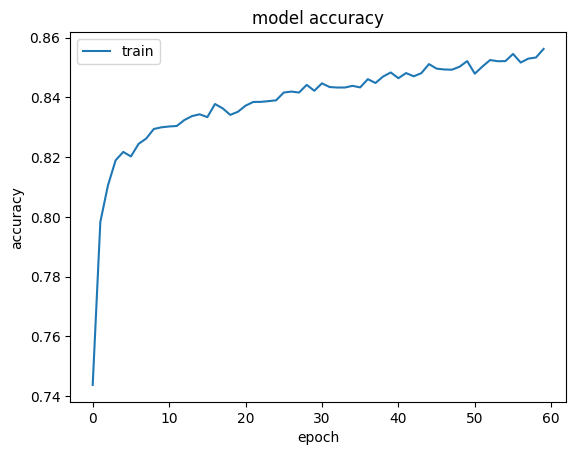

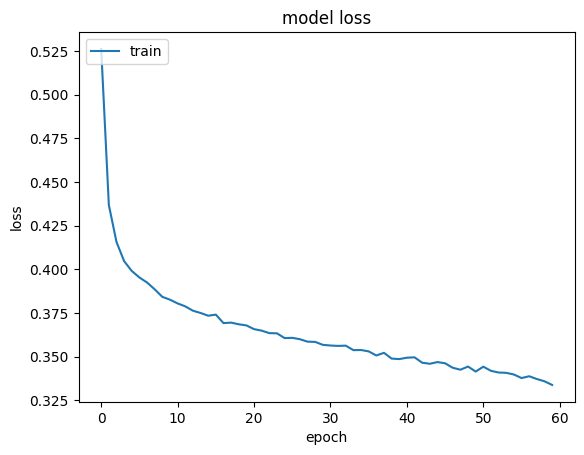

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_df = tfds.as_dataframe(imdb['test'], info)

In [ ]:
#tokenize the testing data
import string
vector_column = []
for review in test_df.text:
  review = str(review)
  tokens = word_tokenize(review)
  tokens = [w.lower() for w in tokens]

  
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]

  stop_words = set(stopwords.words('english'))
  words = [w for w in stripped if not w in stop_words]
  vector_column.append(words)

test_df['tokens'] = vector_column
test_df.head()

,label,text,tokens
0,1,"b""There are films that make careers. For Georg...","[b, , films, make, careers, , george, romero, ..."
1,1,"b""A blackly comic tale of a down-trodden pries...","[b, , blackly, comic, tale, downtrodden, pries..."
2,0,"b'Scary Movie 1-4, Epic Movie, Date Movie, Mee...","[bscary, movie, 14, , epic, movie, , date, mov..."
3,0,b'Poor Shirley MacLaine tries hard to lend som...,"[bpoor, shirley, maclaine, tries, hard, lend, ..."
4,1,b'As a former Erasmus student I enjoyed this f...,"[bas, former, erasmus, student, enjoyed, film,..."


In [ ]:
#same as above (sory dry)
encoding_column = []
for token_array in test_df.tokens:
  #review_vector = [0]*len(vector_ordering)
  review_vector = []
  tokens = token_array
  for token in tokens:
    #this if statement is important for when new words appear
    if token in model.wv.key_to_index:
      review_vector.append(model.wv[token])
    #print(review_vector)
  review_vector = np.asarray(review_vector)
  encoding_column.append(np.mean(review_vector, axis = 0))
encoding_column = np.asarray(encoding_column)


(25000, 100)
[-4.84497219e-01  5.38630724e-01  2.99075067e-01  2.33391255e-01
  2.11977325e-02 -1.16719937e+00  3.04096133e-01  1.06690192e+00
 -2.95175999e-01 -5.30470788e-01  4.09239382e-01 -4.85964596e-01
 -4.56335157e-01  3.87517065e-01 -3.62348020e-01 -9.28322822e-02
  6.61338031e-01 -5.94161600e-02 -4.83047456e-01 -5.32141328e-01
  9.95494127e-01 -1.43043652e-01  4.04388532e-02 -2.16327891e-01
  5.72875202e-01  1.84110105e-01 -3.58891457e-01 -1.75853416e-01
 -9.56931055e-01 -2.54663318e-01  6.04220815e-02 -2.78843015e-01
  2.23640218e-01 -2.67456651e-01  2.58727789e-01 -3.79553088e-03
  5.12424469e-01  7.90972412e-02  3.54909629e-01 -2.36246705e-01
  7.45975152e-02  2.07986578e-01 -6.29394650e-01 -9.03503001e-02
  1.22223973e-01 -1.19815962e-02 -2.38645539e-01  2.52692699e-01
  5.33902824e-01  4.31692781e-04 -5.68620600e-02  1.93070173e-01
 -1.21783346e-01  1.84039727e-01  8.35606039e-01 -4.31901336e-01
  2.85624087e-01 -3.74431789e-01 -1.72116786e-01  2.76079178e-01
 -2.77447075

In [ ]:
X_test = encoding_column
Y_test = np.asarray(test_df['label']).astype(np.float32)


[[-0.43643185  0.5119336   0.2586563  ... -0.5770197  -0.37618208
   0.1604772 ]
 [-0.53082013  0.38679048  0.13743621 ... -0.6382638  -0.36665893
   0.05712708]
 [-0.48449722  0.5386307   0.29907507 ... -0.6003924  -0.35079563
   0.00881884]
 ...
 [-0.37863243  0.7833113   0.20187649 ... -0.47362977 -0.31893083
   0.29126734]
 [-0.6819101   0.44337523  0.4560603  ... -0.6963729  -0.5020327
   0.39827478]
 [-0.46770868  0.45031643  0.16439526 ... -0.56366986 -0.4418257
  -0.01281731]]
[1. 1. 0. ... 0. 1. 1.]


In [ ]:
test_results = s_model.evaluate(X_test, Y_test)
print(test_results)

782/782 [==============================] - 2s 3ms/step - loss: 0.3959 - accuracy: 0.8141
[0.3958771526813507, 0.8141199946403503]


In [ ]:
#Make predictions for the test dataset
y_prediction = s_model.predict(X_test)
#Convert to a classification prediciton either 0 or 1
y_prediction_class = np.round(y_prediction)
print(y_prediction_class[:15])
print(Y_test[:15])

782/782 [==============================] - 1s 2ms/step
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]]
[1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, recall_score, precision_score, accuracy_score

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, y_prediction_class))
# The recall
print("Recall: %.2f" % recall_score(Y_test, y_prediction_class))
# The precision
print("Precision: %.2f" % precision_score(Y_test, y_prediction_class))
# The accuracy
print("Accuracy: %.2f" % accuracy_score(Y_test, y_prediction_class))


Mean squared error: 0.19
Recall: 0.70
Precision: 0.91
Accuracy: 0.81


In [ ]:
test_df.text[0]#The model says the is negative but it is labeled as positive, I am not sure why the model predicts this so poorly

b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."

In [ ]:
test_df.text[13]#The model says the is negative but it is labeled as positive, I am not sure why the model predicts this so poorly

b'I saw this movie as part of a Billy Graham program. The church I attend was part of a community wide outreach to present God and Christianity to our community (Hartford, Ct. USA). I was one of the counselors who helped attendees (who were invited to come forward and make whatever kind of religious profession they wanted...and to follow up on them after the movie. As such, it did what it was supposed to do, and I personally found it to be a medium to strengthen my faith in God.I also found it to be very helpful to those I counseled. I especially like the work of Kim Darby in this movie. And the parents (the Wintons?) were , in a way, a little overdrawn....no one says to their child if they think that he or she may be the parent of an illegitimate child something like the Wintons did "oh, no, no, not thaaat." That isn\'t exactly what they said, but the sympaathetic audience I saw had a laugh at whatever it was they did say, and also at the son\'s emphatic "No, MOm, not me." Don Berghui